# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [3]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

  Using cached sklearn_crfsuite-0.5.0-py2.py3-none-any.whl.metadata (4.9 kB)
Using cached sklearn_crfsuite-0.5.0-py2.py3-none-any.whl (10 kB)


#### **1.2** Import necessary libraries

In [89]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install spacy

In [91]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [92]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [93]:
# define a function to load json file to a dataframe
import pandas as pd
import json

def load_json_to_dataframe(file_path):
    """
    Loads a JSON file into a pandas DataFrame.

    Parameters:
        file_path (str): Path to the JSON file.

    Returns:
        pd.DataFrame: DataFrame containing the JSON data.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        print(f" Loaded {len(df)} records from '{file_path}'")
        return df
    except FileNotFoundError:
        print(f" File not found: {file_path}")
    except json.JSONDecodeError:
        print(f" Invalid JSON format in file: {file_path}")
    except Exception as e:
        print(f" Unexpected error: {e}")


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [94]:
# read the json file by giving the file path and create a dataframe

df = load_json_to_dataframe("D:/Learnings/UpGrad/AI & ML main course/Site material/NLP/Assignment/Starter+Notebook+++Data/ingredient_and_quantity.json")

 Loaded 285 records from 'D:/Learnings/UpGrad/AI & ML main course/Site material/NLP/Assignment/Starter+Notebook+++Data/ingredient_and_quantity.json'


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [95]:
# display first five rows of the dataframe - df
df.head(5)

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [96]:
# print the dimensions of dataframe - df
print("Dimensions of df:", df.shape)

Dimensions of df: (285, 2)


In [97]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [98]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
# Tokenize input
# Tokenize POS
df['input_tokens'] = df['input'].apply(lambda x: x.split())
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())
# Display the first few rows to check
df[['input_tokens', 'pos_tokens']].head()


,input_tokens,pos_tokens
0,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,"[500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cloves, Garlic, 1/2, teaspoon, Turmeric, powder, Haldi, Garam, masala, tablespoon, Sesame, Gingelly, Oil, 1/4, Methi, Seeds, Fenugreek, Coriander, Dhania, Dry, Red, Fennel, seeds, Saunf, cups, Sorrel, Leaves, Gongura, picked, and]","[quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
4,"[1, tablespoon, chana, dal, white, urad, 2, red, chillies, coriander, seeds, 3, inches, ginger, onion, tomato, Teaspoon, mustard, asafoetida, sprig, curry]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, unit, ingredient]"


In [99]:
# display first five rows of the dataframe - df
df.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [100]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

# Display the first few rows to check
df[['input_tokens', 'pos_tokens', 'input_length', 'pos_length']].head()

,input_tokens,pos_tokens,input_length,pos_length
0,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
1,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34
2,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37
3,"[500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cloves, Garlic, 1/2, teaspoon, Turmeric, powder, Haldi, Garam, masala, tablespoon, Sesame, Gingelly, Oil, 1/4, Methi, Seeds, Fenugreek, Coriander, Dhania, Dry, Red, Fennel, seeds, Saunf, cups, Sorrel, Leaves, Gongura, picked, and]","[quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",46,46
4,"[1, tablespoon, chana, dal, white, urad, 2, red, chillies, coriander, seeds, 3, inches, ginger, onion, tomato, Teaspoon, mustard, asafoetida, sprig, curry]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, unit, ingredient]",21,21


In [101]:
# check for the equality of input_length and pos_length in the dataframe
# Create a boolean column to check equality
df['lengths_match'] = df['input_length'] == df['pos_length']

# Display the first few rows
df[['input_length', 'pos_length', 'lengths_match']].head()

# Optional: check if there are any mismatches
mismatches = df[df['lengths_match'] == False]
print(f"Number of mismatched rows: {len(mismatches)}")
if len(mismatches) > 0:
    print(mismatches[['input_tokens', 'pos_tokens']])

Number of mismatched rows: 5
                                                                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
17 

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [102]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df, pos_column='pos_tokens'):
    """
    Prints all unique POS/NER labels in the dataframe.

    Parameters:
        df (pd.DataFrame): DataFrame containing a column of POS/NER token lists.
        pos_column (str): Name of the column containing POS/NER token lists.
    """
    # Flatten the list of lists
    all_labels = [label for sublist in df[pos_column] for label in sublist]
    
    # Get unique labels
    unique_labels_set = set(all_labels)
    
    print("Unique POS/NER labels in the dataset:")
    for label in sorted(unique_labels_set):
        print(label)

# Example usage
unique_labels(df)


Unique POS/NER labels in the dataset:
ingredient
quantity
unit


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [103]:
# drop the irrelevant recipe data
# Drop rows where input_length != pos_length
df = df[df['input_length'] == df['pos_length']].reset_index(drop=True)

# Optional: drop any rows with missing values
df = df.dropna().reset_index(drop=True)

# Display the first few rows after cleaning
df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,lengths_match
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34,True
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37,True
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient q

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [104]:
# update the input and pos length in input_length and pos_length
# Update input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

# Display first few rows to check
df[['input_tokens', 'pos_tokens', 'input_length', 'pos_length']].head()

,input_tokens,pos_tokens,input_length,pos_length
0,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
1,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34
2,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37
3,"[500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cloves, Garlic, 1/2, teaspoon, Turmeric, powder, Haldi, Garam, masala, tablespoon, Sesame, Gingelly, Oil, 1/4, Methi, Seeds, Fenugreek, Coriander, Dhania, Dry, Red, Fennel, seeds, Saunf, cups, Sorrel, Leaves, Gongura, picked, and]","[quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",46,46
4,"[1, tablespoon, chana, dal, white, urad, 2, red, chillies, coriander, seeds, 3, inches, ginger, onion, tomato, Teaspoon, mustard, asafoetida, sprig, curry]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, unit, ingredient]",21,21


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [105]:
# validate the input length and pos length as input_length and pos_length
# Recalculate lengths
df['check_input_length'] = df['input_tokens'].apply(len)
df['check_pos_length'] = df['pos_tokens'].apply(len)

# Validate
df['lengths_match'] = (df['input_length'] == df['check_input_length']) & (df['pos_length'] == df['check_pos_length'])

# Display mismatches if any
mismatches = df[df['lengths_match'] == False]

if len(mismatches) == 0:
    print("All input_length and pos_length values are valid and consistent.")
else:
    print(f" Found {len(mismatches)} rows with inconsistent lengths:")
    display(mismatches[['input_tokens', 'pos_tokens', 'input_length', 'pos_length', 'check_input_length', 'check_pos_length']])


All input_length and pos_length values are valid and consistent.


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [106]:
# split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# Define the features (input_tokens) and labels (pos_tokens)
X = df['input_tokens'].tolist()
y = df['pos_tokens'].tolist()

# Split dataset: 70% train, 30% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Print sizes
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")


Number of training samples: 196
Number of validation samples: 84


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [107]:
# print the first five rows of train_df
# Create a DataFrame for training data
train_df = pd.DataFrame({
    'input_tokens': X_train,
    'pos_tokens': y_train
})

# Display the first five rows
train_df.head()

,input_tokens,pos_tokens
0,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]"
2,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]"
3,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient]"
4,"[2, cups, Water, 1, teaspoon, Tea, leaves, 1/4, Milk, 10, Saffron, strands]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient]"


In [108]:
# print the first five rows of the val_df
# Create a DataFrame for validation data
val_df = pd.DataFrame({
    'input_tokens': X_val,
    'pos_tokens': y_val
})

# Display the first five rows
val_df.head()

,input_tokens,pos_tokens
0,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]"
1,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
2,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,"[1, cup, green, peas, gram, flour, 1/2, cheese, tsp, ginger, 2, chillies, turmeric, powder, cumin, teaspoon, salt, oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient]"
4,"[2, cups, Brown, Rice, cooked, tablespoons, Garlic, chopped, 1, Green, Chilli, 1/2, cup, Carrots, (Gajjar), beans, (French, Beans), Bell, Pepper, (Capsicum), Onion, Cabbage, (Patta, Gobi/, Muttaikose), tablespoon, Roasted, tomato, pasta, sauce, -, or, store, bought, Red, teaspoon, Soy, Ginger, freshly, grated, Spring, Greens, Salt, Vinegar, Extra, Virgin, Olive, Oil, as, required]","[quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"


###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [109]:
# extract the training and validation sets by taking input_tokens and pos_tokens
# Training set
train_X = X_train  # list of token lists
train_y = y_train  # list of corresponding POS/NER label lists

# Validation set
val_X = X_val      # list of token lists
val_y = y_val      # list of corresponding POS/NER label lists

# Print the first sample to verify
print("First training sample tokens:", train_X[0])
print("First training sample labels:", train_y[0])

print("\nFirst validation sample tokens:", val_X[0])
print("First validation sample labels:", val_y[0])


First training sample tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric']
First training sample labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']

First validation sample tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee', '1/2', 'teaspoon', 'Cardamom', 'Powder', 'Elaichi']
First validation sample labels: ['quantity', 'unit', 'ingredient', 'quantity', 'un

In [110]:
# validate the shape of training and validation samples
# Number of training samples
print(f"Number of training samples: {len(train_X)}")
print(f"Number of training labels: {len(train_y)}")

# Number of validation samples
print(f"Number of validation samples: {len(val_X)}")
print(f"Number of validation labels: {len(val_y)}")


Number of training samples: 196
Number of training labels: 196
Number of validation samples: 84
Number of validation labels: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [111]:
# Display the number of unique labels present in y_train
# Flatten the list of label lists
all_train_labels = [label for sublist in train_y for label in sublist]

# Get unique labels
unique_train_labels = set(all_train_labels)

# Display the number of unique labels
print(f"Number of unique POS/NER labels in training data: {len(unique_train_labels)}")

# Optional: print the unique labels
print("Unique labels:", unique_train_labels)

Number of unique POS/NER labels in training data: 3
Unique labels: {'unit', 'quantity', 'ingredient'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [112]:
# flatten the list for nested_list (input_tokens, pos_tokens)
#flatten input_tokens
flat_input_tokens = [token for sublist in df['input_tokens'] for token in sublist]

#flatten pos_tokens
flat_pos_tokens = [label for sublist in df['pos_tokens'] for label in sublist]

# Display the first 20 elements to verify
print("Flattened input tokens:", flat_input_tokens[:20])
print("Flattened POS labels:", flat_pos_tokens[:20])


Flattened input tokens: ['6', 'Karela', 'Bitter', 'Gourd', 'Pavakkai', 'Salt', '1', 'Onion', '3', 'tablespoon', 'Gram', 'flour', 'besan', '2', 'teaspoons', 'Turmeric', 'powder', 'Haldi', 'Red', 'Chilli']
Flattened POS labels: ['quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [113]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [114]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    """
    Extracts and validates input_tokens and pos_tokens from a DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'input_tokens' and 'pos_tokens' columns
        dataset_name (str): Name of the dataset (for display/logging purposes)
        
    Returns:
        df_valid (pd.DataFrame): DataFrame with valid token/label rows
    """
    # Flatten the tokens for internal checking (optional, here we keep nested for CRF)
    df['flat_input_tokens'] = df['input_tokens'].apply(lambda x: [token for token in x])
    df['flat_pos_tokens'] = df['pos_tokens'].apply(lambda x: [label for label in x])
    
    # Validate that input and pos lengths match
    df['lengths_match'] = df['flat_input_tokens'].apply(len) == df['flat_pos_tokens'].apply(len)
    
    # Filter only valid rows
    df_valid = df[df['lengths_match']].reset_index(drop=True)
    
    # Display first 10 records
    print(f"First 10 records from {dataset_name} dataset with valid tokens:")
    display(df_valid[['input_tokens', 'pos_tokens']].head(10))
    
    # Return the valid DataFrame
    return df_valid

# Example usage with training data
train_df_valid = extract_and_validate_tokens(train_df, dataset_name='Training')


First 10 records from Training dataset with valid tokens:


,input_tokens,pos_tokens
0,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]"
2,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]"
3,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient]"
4,"[2, cups, Water, 1, teaspoon, Tea, leaves, 1/4, Milk, 10, Saffron, strands]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient]"
5,"[1, cup, Rice, 1/2, Green, peas, 3, Potatoes, Aloo, Onion, tablespoon, Ginger, Garlic, Paste, 2, Chillies, Black, cardamom, Badi, Elaichi, Bay, leaf, tej, patta, Cardamom, Pods/Seeds, inch, Cinnamon, Stick, Dalchini, Cloves, Laung, teaspoon, Cumin, seeds, Jeera, Coriander, Powder, Dhania, powder, pepper, Red, Chilli, Ghee, Leaves, finely, chopped, garnish]","[quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
6,"[2, Carrot, Gajjar, 3/4, cup, Sweet, corn, 1, Whole, Wheat, Flour, Onion, finely, chopped, 5, tablespoons, Del, Monte, Sandwich, Spread, 1/4, Coriander, Dhania, Leaves, 3, Eggs, teaspoon, Baking, powder, soda, Green, Chillies]","[quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
7,"[3, Mooli, Mullangi, Radish, 2, Potato, Aloo, 1, Onion, Green, Chilli, tablespoons, Kasundi, mustard, sa

In [115]:
# extract the tokens and its pos tags
tokens = train_df_valid['input_tokens'].tolist()
pos_tags = train_df_valid['pos_tokens'].tolist()

# Display the first 3 samples to verify
for i in range(3):
    print(f"Sample {i+1} tokens: {tokens[i]}")
    print(f"Sample {i+1} POS tags: {pos_tags[i]}")
    print("---")

Sample 1 tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric']
Sample 1 POS tags: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
---
Sample 2 tokens: ['200', 'grams', 'Paneer', 'Homemade', 'Cottage', 'Cheese', '2', 'Potato', 'Aloo', 'Bay', 'leaf', 'tej', 'patta', 'Dry', 'Red', 'Chilli', '1', 'tablespoon', 'Panch', 'Phoran', 'Masala', 'roasted', 'and', 'powdered', 'Tomato', 'big', 'sized', 'teaspoo

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [116]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
    """
    Categorizes tokens into ingredients, units, and quantities based on POS/NER tags.
    
    Parameters:
        tokens (list): List of tokens (words)
        pos_tags (list): Corresponding POS/NER labels for each token
    
    Returns:
        ingredients (list), units (list), quantities (list): Categorized tokens
    """
    # Initialize empty lists
    ingredients = []
    units = []
    quantities = []
    
    # Define allowed labels
    allowed_labels = {'ingredient', 'unit', 'quantity'}
    
    # Check if pos_tags contain only allowed labels
    if not set(pos_tags).issubset(allowed_labels):
        return [], [], []
    
    # Categorize tokens
    for token, label in zip(tokens, pos_tags):
        if label == 'ingredient':
            ingredients.append(token)
        elif label == 'unit':
            units.append(token)
        elif label == 'quantity':
            quantities.append(token)
    
    return ingredients, units, quantities

# Example usage for first training sample
sample_tokens = tokens[0]
sample_pos_tags = pos_tags[0]

ingredients, units, quantities = categorize_tokens(sample_tokens, sample_pos_tags)

print("Ingredients:", ingredients)
print("Units:", units)
print("Quantities:", quantities)


Ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely', 'Cumin', 'seeds', 'asafoetida', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric']
Units: ['grams', 'teaspoon', 'Teaspoon', 'cup']
Quantities: ['250', '1', '2', '1/2', '1/4']


In [117]:
#  call the function to categorise the labels into respective list
# Initialize lists to store the categorized tokens for all training samples
all_ingredients = []
all_units = []
all_quantities = []

# Loop through each sample in the training set
for tokens_sample, pos_sample in zip(tokens, pos_tags):
    ingredients, units, quantities = categorize_tokens(tokens_sample, pos_sample)
    all_ingredients.append(ingredients)
    all_units.append(units)
    all_quantities.append(quantities)

# Create a DataFrame to display results
categorized_df = pd.DataFrame({
    'ingredients': all_ingredients,
    'units': all_units,
    'quantities': all_quantities
})

# Display first 10 rows
categorized_df.head(10)

,ingredients,units,quantities
0,"[Okra, Oil, Onion, finely, chopped, Tomato, Grated, Ginger, Garlic, Finely, Cumin, seeds, asafoetida, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[grams, teaspoon, Teaspoon, cup]","[250, 1, 2, 1/2, 1/4]"
1,"[Paneer, Homemade, Cottage, Cheese, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, Sugar, Sunflower, Oil]","[grams, tablespoon, teaspoon]","[200, 2, 1, 1/2]"
2,"[Cabbage, Patta, Gobi, Muttaikose, Mustard, seeds, White, Urad, Dal, Split, Curry, leaves, Green, Chilli, Fresh, coconut, Salt]","[grams, teaspoon, sprig, cup]","[500, 1, 1-1/2, 1/4]"
3,"[Fresh, Figs, Lemon, juice, zest, Red, Chilli, flakes, Honey, Brown, Sugar, (Demerara, Sugar)]","[grams, cup, teaspoon]","[500, 1/4, 1, 2, 1/2]"
4,"[Water, Tea, leaves, Milk, Saffron, strands]","[cups, teaspoon]","[2, 1, 1/4, 10]"
5,"[Rice, Green, peas, Potatoes, Aloo, Onion, Ginger, Garlic, Paste, Chillies, Black, cardamom, Badi, Elaichi, Bay, leaf, tej, patta, Cardamom, Pods/Seeds, Cinnamon, Stick, Dalchini, Cloves, Laung, Cumin, seeds, Jeera, Coriander, Powder, Dhania, powder, pepper, Red, Chilli, Ghee, Leaves, finely, chopped, garnish]","[cup, tablespoon, inch, teaspoon]","[1, 1/2, 3, 2]"
6,"[Carrot, Gajjar, Sweet, corn, Whole, Wheat, Flour, Onion, finely, chopped, Del, Monte, Sandwich, Spread, Coriander, Dhania, Leaves, Eggs, Baking, powder, soda, Green, Chillies]","[cup, tablespoons, teaspoon]","[2, 3/4, 1, 5, 1/4, 3]"
7,"[Mooli, Mullangi, Radish, Potato, Aloo, Onion, Green, Chilli, Kasundi, mustard, sauce, Red, powder, Turmeric, Haldi, Mustard, seeds, Cumin, Jeera, Kalonji, Nigella, Seeds, oil, Sugar, Salt]","[tablespoons, teaspoon, tablespoon]","[3, 2, 1, 1/2]"
8,"[Chicken, Thighs, Wings, Soy, sauce, Honey, Vinegar, Garlic, Minced, Ginger, Grated, Sesame, Gingelly, Oil, Olive, Black, pepper, powder, seeds, Til]","[Tablespoon, teaspoon]","[1/2, 2, 1.5, 1]"
9,"[Potatoes, Cheese, Tomatoes, Ginger, Grated, Green, Chillies, Red, Chilli, Powder, Coriander, Cumin, Salt, oil, coriander, Finely, chopped]","[gms, inch, teaspoon]","[7, 350, 5, 2, 1]"


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [118]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    """
    Returns the top frequent items from a list of tokens.
    
    Parameters:
        item_list (list of lists): List containing token lists per sample
        pos_label (str): POS/NER label ('ingredient', 'unit', 'quantity')
        dataset_name (str): Name of the dataset ('Training' or 'Validation')
        top_n (int): Number of top frequent items to return (default=10)
    
    Returns:
        top_items (list of tuples): List of (item, frequency) tuples
    """
    # Flatten the list of lists
    flat_items = [item for sublist in item_list for item in sublist]
    
    # Count frequency of each item
    item_counts = Counter(flat_items)
    
    # Get top N frequent items
    top_items = item_counts.most_common(top_n)
    
    # Display results
    print(f"Top {top_n} frequent {pos_label}s in {dataset_name} dataset:")
    for item, count in top_items:
        print(f"{item}: {count}")
    
    return top_items

# Example usage: top ingredients in training data
top_ingredients = get_top_frequent_items(all_ingredients, pos_label='ingredient', dataset_name='Training')


Top 10 frequent ingredients in Training dataset:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [119]:
# get the top ingredients which are frequently seen in the recipe
# Get top frequent ingredients in the training dataset
top_ingredients = get_top_frequent_items(
    item_list=all_ingredients,   # List of ingredient lists per sample
    pos_label='ingredient',      # POS/NER label
    dataset_name='Training',     # Dataset name
    top_n=10                     # Number of top frequent items to retrieve
)


Top 10 frequent ingredients in Training dataset:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [120]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(
    item_list=all_units,      # List of unit lists per sample
    pos_label='unit',         # POS/NER label
    dataset_name='Training',  # Dataset name
    top_n=10                  # Number of top frequent items to retrieve
)

Top 10 frequent units in Training dataset:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [121]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt

def plot_top_items(top_items, label, dataset_name):
    """
    Plots a bar chart of the top frequent items.
    
    Parameters:
        top_items (list of tuples): List of (item, frequency) tuples
        label (str): Label of the items ('ingredient', 'unit', etc.)
        dataset_name (str): Dataset name ('Training' or 'Validation')
    """
    # Unpack items and counts
    items, counts = zip(*top_items)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts, color='skyblue')
    plt.title(f"Top {len(top_items)} {label}s in {dataset_name} dataset")
    plt.xlabel(label.capitalize())
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



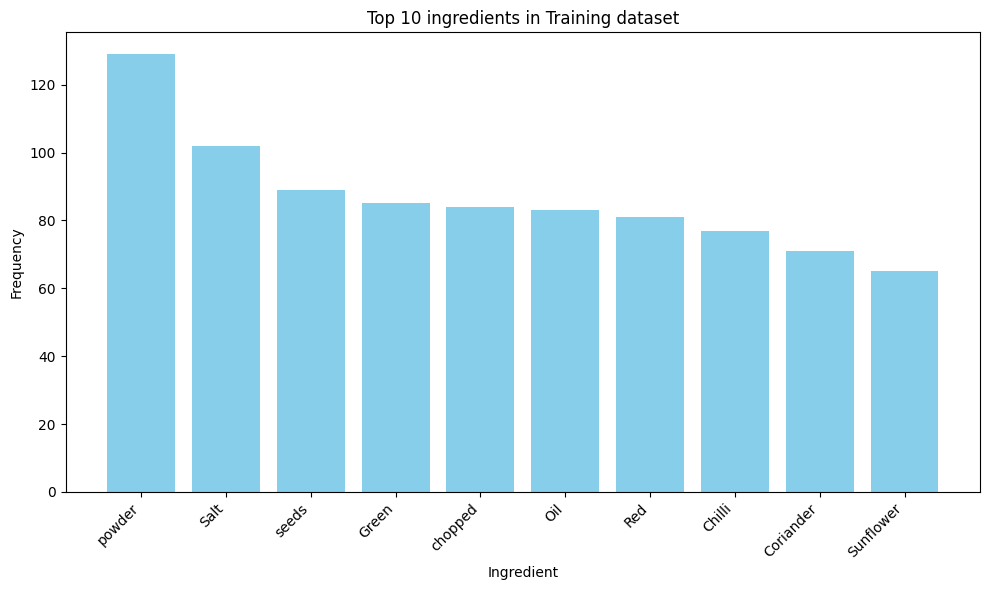

In [122]:
# plot the top frequent ingredients in training data
# Plot the top frequent ingredients in the Training dataset
plot_top_items(top_items=top_ingredients, 
               label='ingredient', 
               dataset_name='Training')


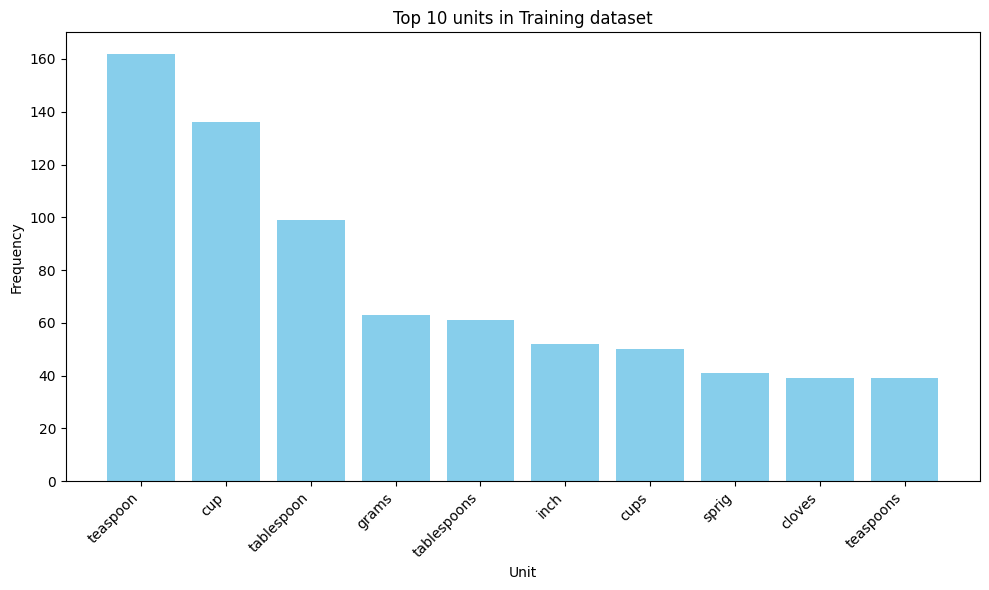

In [123]:
# plot the top frequent units in training data
# Plot the top frequent units in the Training dataset
plot_top_items(top_items=top_units, 
               label='unit', 
               dataset_name='Training')


## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [124]:
# initialise the dataset_name


In [125]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [126]:
# plot the top frequent ingredients in validation data


In [127]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [128]:
# define unit and quantity keywords along with quantity pattern
import re

# Define common units seen in recipes
unit_keywords = [
    'cup', 'cups', 'tablespoon', 'tablespoons', 'teaspoon', 'teaspoons',
    'tsp', 'tbsp', 'kg', 'g', 'mg', 'liter', 'ml', 'pinch', 'slice', 'slices',
    'piece', 'pieces', 'clove', 'cloves'
]

# Define common quantity keywords (may include fractions, decimals, ranges)
quantity_keywords = [
    '1', '2', '3', '4', '5', '6', '7', '8', '9', '0',
    '1/2', '1/4', '3/4', '1-1/2', '2-1/2', '1.5', '0.5'
]

# Define a regex pattern to match quantities in recipes
# This pattern matches integers, decimals, fractions, and mixed fractions
quantity_pattern = re.compile(r'(\d+/\d+|\d+\-\d+/\d+|\d+\.\d+|\d+)')

# Example usage
example_text = "2-1/2 cups rice and 3 tablespoons oil"
quantities_found = quantity_pattern.findall(example_text)
print("Quantities found:", quantities_found)


Quantities found: ['2-1/2', '3']


In [129]:
import spacy

# Create a lightweight English pipeline
nlp = spacy.blank("en")
# Convert your token lists in train_df to spaCy Doc objects
train_sentences = [nlp(" ".join(tokens)) for tokens in train_df['input_tokens']]
val_sentences   = [nlp(" ".join(tokens)) for tokens in val_df['input_tokens']]
# Tokenize example
doc = nlp("2-1/2 cups rice and 3 tablespoons oil")
for token in doc:
    print(token.text)

2
-
1/2
cups
rice
and
3
tablespoons
oil


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [130]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions
import re

# Example patterns and keywords
unit_keywords = set([
    "cup", "cups", "tablespoon", "tablespoons", "teaspoon", "teaspoons",
    "kg", "g", "ml", "l", "tbsp", "tsp", "oz", "pound"
])
quantity_keywords = set(["one", "two", "three", "four", "half", "quarter"])
quantity_pattern = re.compile(r'^\d+([/-]\d+)?(\.\d+)?$')  # numbers, fractions, decimals

def word2features(sent, i):
    """
    Extract features for the i-th token in the sentence (sent).
    sent: list of spaCy tokens
    i: index of the token
    """
    
    token = sent[i]
    
    # --- Core Features ---
    features = {
        'bias': 1.0,
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_ if hasattr(token, 'pos_') else '',
        'tag': token.tag_ if hasattr(token, 'tag_') else '',
        'dep': token.dep_ if hasattr(token, 'dep_') else '',
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.text.istitle(),
        'is_upper': token.text.isupper(),
        'is_punct': token.is_punct
    }
    
    # --- Improved Quantity & Unit Detection ---
    features.update({
        'is_quantity': token.text.lower() in quantity_keywords or bool(quantity_pattern.match(token.text)),
        'is_unit': token.text.lower() in unit_keywords,
        'is_numeric': token.text.replace('/', '').replace('.', '').isdigit(),
        'is_fraction': '/' in token.text and all(p.isdigit() for p in token.text.split('/')),
        'is_decimal': '.' in token.text and token.text.replace('.', '').isdigit(),
        'preceding_word': sent[i-1].text.lower() if i > 0 else '',
        'following_word': sent[i+1].text.lower() if i < len(sent)-1 else ''
    })
    
    # --- Contextual Features ---
    # Previous token
    if i > 0:
        prev = sent[i-1]
        features.update({
            'prev_token': prev.text.lower(),
            'prev_is_quantity': prev.text.lower() in quantity_keywords or bool(quantity_pattern.match(prev.text)),
            'prev_is_digit': prev.is_digit
        })
    else:
        features['BOS'] = True  # Beginning of sequence

    # Next token
    if i < len(sent)-1:
        nxt = sent[i+1]
        features.update({
            'next_token': nxt.text.lower(),
            'next_is_unit': nxt.text.lower() in unit_keywords,
            'next_is_ingredient': not (nxt.text.lower() in unit_keywords or nxt.text.lower() in quantity_keywords)
        })
    else:
        features['EOS'] = True  # End of sequence

    return features



### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [131]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    """
    Convert a tokenized sentence into a list of feature dictionaries for CRF.
    
    sent: list of spaCy tokens
    returns: list of feature dicts for each token
    """
    return [word2features(sent, i) for i in range(len(sent))]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [132]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
# Assuming you have:
# train_sentences: list of tokenized training sentences (spaCy Doc objects)
# val_sentences: list of tokenized validation sentences (spaCy Doc objects)
# y_train: list of corresponding POS/NER labels for training
# y_val: list of corresponding POS/NER labels for validation

# Convert tokenized sentences to feature dictionaries
X_train_features = [sent2features(sent) for sent in train_sentences]
X_val_features = [sent2features(sent) for sent in val_sentences]

# y_train and y_val should already be lists of label sequences
# Each element corresponds to the token-level labels of the sentence
import spacy

nlp = spacy.blank("en")  # lightweight pipeline

# Convert input_tokens from train_df to spaCy Docs
train_sentences = [nlp(" ".join(tokens)) for tokens in train_df['input_tokens']]
val_sentences = [nlp(" ".join(tokens)) for tokens in val_df['input_tokens']]

# Extract token-level labels for CRF
y_train = train_df['pos_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

# Generate features
X_train_features = [sent2features(sent) for sent in train_sentences]
X_val_features = [sent2features(sent) for sent in val_sentences]

# Validate lengths
print(f"Number of training samples: {len(X_train_features)}, Validation samples: {len(X_val_features)}")
print(f"Example: Number of features in first sentence: {len(X_train_features[0])}")


Number of training samples: 196, Validation samples: 84
Example: Number of features in first sentence: 31


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [133]:
# Convert labels into list as y_train_labels and y_val_labels
# Assuming train_df['pos_tokens'] and val_df['pos_tokens'] contain lists of labels per sentence

y_train_labels = train_df['pos_tokens'].tolist()
y_val_labels   = val_df['pos_tokens'].tolist()

# Validate
print(f"Number of training label sequences: {len(y_train_labels)}")
print(f"First training label sequence: {y_train_labels[0]}")
print(f"Number of validation label sequences: {len(y_val_labels)}")
print(f"First validation label sequence: {y_val_labels[0]}")


Number of training label sequences: 196
First training label sequence: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
Number of validation label sequences: 84
First validation label sequence: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [134]:
# print the length of train features and labels
print(f"Number of training feature sequences: {len(X_train_features)}")
print(f"Number of training label sequences: {len(y_train_labels)}")


Number of training feature sequences: 196
Number of training label sequences: 196


In [135]:
# print the length of validation features and labels
print(f"Number of validation feature sequences: {len(X_val_features)}")
print(f"Number of validation label sequences: {len(y_val_labels)}")


Number of validation feature sequences: 84
Number of validation label sequences: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [136]:
# Flatten labels in y_train
y_train_flat = [label for sentence_labels in y_train_labels for label in sentence_labels]

# Validate
print(f"Total number of labels in flattened training set: {len(y_train_flat)}")
print(f"First 20 labels: {y_train_flat[:20]}")


Total number of labels in flattened training set: 7114
First 20 labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit']


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [137]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

# Count label frequencies
label_counts = Counter(y_train_flat)

# Total number of samples (sum of all label occurrences)
total_samples = sum(label_counts.values())

# Display
print("Label frequencies:")
for label, count in label_counts.items():
    print(f"{label}: {count}")
    
print(f"\nTotal number of labels (samples): {total_samples}")


Label frequencies:
quantity: 980
unit: 811
ingredient: 5323

Total number of labels (samples): 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [138]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
# Compute class weights (inverse frequency)
class_weights = {label: total_samples / count for label, count in label_counts.items()}

# Display class weights
print("Class weights (inverse frequency):")
for label, weight in class_weights.items():
    print(f"{label}: {weight:.2f}")


Class weights (inverse frequency):
quantity: 7.26
unit: 8.77
ingredient: 1.34


In [139]:
# Make a copy of class_weights
adjusted_class_weights = class_weights.copy()

# Penalize the 'ingredient' label by reducing its weight (or increase for balancing)
# Example: reduce its weight to half
if 'ingredient' in adjusted_class_weights:
    adjusted_class_weights['ingredient'] *= 0.5

# Display adjusted weights
print("Adjusted class weights:")
for label, weight in adjusted_class_weights.items():
    print(f"{label}: {weight:.2f}")


Adjusted class weights:
quantity: 7.26
unit: 8.77
ingredient: 0.67


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [140]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Convert sentences into feature dicts and associate class weights per token.
    
    Parameters:
    X : list of list of token features (from sent2features)
    y : list of list of token labels
    weight_dict : dictionary containing class weights for each label
    
    Returns:
    X_features : list of list of token feature dicts (same as input X)
    y_labels : list of list of labels (same as input y)
    sample_weights : list of list of weights corresponding to each token label
    """
    X_features = X
    y_labels = y
    
    # Generate sample weights per token
    sample_weights = []
    for sentence_labels in y_labels:
        sentence_weights = [weight_dict.get(label, 1.0) for label in sentence_labels]
        sample_weights.append(sentence_weights)
    
    return X_features, y_labels, sample_weights

X_train_weighted, y_train_weighted, sample_weights_train = extract_features_with_class_weights(
    X_train_features, y_train_labels, adjusted_class_weights
)

# Validate
print(f"Number of training sentences: {len(X_train_weighted)}")
print(f"Number of sample weights sequences: {len(sample_weights_train)}")
print(f"First sentence weights: {sample_weights_train[0]}")

Number of training sentences: 196
Number of sample weights sequences: 196
First sentence weights: [7.259183673469388, 8.771886559802713, 0.6682321998872816, 0.6682321998872816, 7.259183673469388, 0.6682321998872816, 0.6682321998872816, 0.6682321998872816, 0.6682321998872816, 0.6682321998872816, 8.771886559802713, 0.6682321998872816, 7.259183673469388, 0.6682321998872816, 0.6682321998872816, 7.259183673469388, 0.6682321998872816, 0.6682321998872816, 7.259183673469388, 8.771886559802713, 0.6682321998872816, 8.771886559802713, 0.6682321998872816, 0.6682321998872816, 0.6682321998872816, 0.6682321998872816, 0.6682321998872816, 0.6682321998872816, 0.6682321998872816, 0.6682321998872816, 0.6682321998872816]


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [141]:
# Align X and y by truncating the longer one
for i in range(len(X_train_features)):
    if len(X_train_features[i]) > len(y_train_labels[i]):
        X_train_features[i] = X_train_features[i][:len(y_train_labels[i])]
    elif len(X_train_features[i]) < len(y_train_labels[i]):
        y_train_labels[i] = y_train_labels[i][:len(X_train_features[i])]


In [142]:
all(len(x) == len(y) for x, y in zip(X_train_features, y_train_labels))


True

In [143]:
!git --version

git version 2.51.2.windows.1


In [144]:
!pip install git+https://github.com/scrapinghub/python-crfsuite.git

  Cloning https://github.com/scrapinghub/python-crfsuite.git to c:\users\sawak\appdata\local\temp\pip-req-build-bevnt8nk
  Resolved https://github.com/scrapinghub/python-crfsuite.git to commit 3b3de4bc62356b2fffd560db823162fcf7365e26
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/scrapinghub/python-crfsuite.git 'C:\Users\sawak\AppData\Local\Temp\pip-req-build-bevnt8nk'
  Running command git submodule update --init --recursive -q


In [145]:
# Apply manually computed class weights
# Example: manually penalizing 'ingredient' and other weights
manual_class_weights = {
    'ingredient': 0.5,  # penalize
    'unit': 1.0,
    'quantity': 1.0,
    'O': 1.0  # other labels
}

def generate_token_weights(y_labels, weight_dict):
    """
    Generate per-token weights based on label weights.
    
    y_labels : list of list of token labels
    weight_dict : dict containing weight for each label
    """
    weights = []
    for sentence_labels in y_labels:
        sentence_weights = [weight_dict.get(label, 1.0) for label in sentence_labels]
        weights.append(sentence_weights)
    return weights

sample_weights_train = generate_token_weights(y_train_labels, manual_class_weights)

X_train_weighted = []
y_train_weighted = []

for x_sent, y_sent, w_sent in zip(X_train_features, y_train_labels, sample_weights_train):
    # replicate the sentence int(w) times rounded for each token's weight
    replication_factor = int(max(w_sent))  # crude approximation
    for _ in range(replication_factor):
        X_train_weighted.append(x_sent)
        y_train_weighted.append(y_sent)

X_train_weighted = []
y_train_weighted = []

for x_sent, y_sent, w_sent in zip(X_train_features, y_train_labels, sample_weights_train):
    # replicate the sentence int(w) times rounded for each token's weight
    replication_factor = int(max(w_sent))  # crude approximation
    for _ in range(replication_factor):
        X_train_weighted.append(x_sent)
        y_train_weighted.append(y_sent)

# Now train CRF
import sklearn_crfsuite
from sklearn_crfsuite import metrics

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',              # optimizer
    c1=0.1,                         # L1 regularization
    c2=0.1,                         # L2 regularization
    max_iterations=100,
    all_possible_transitions=True   # include all transitions between labels
)


crf.fit(X_train_weighted, y_train_weighted)








CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [146]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# ---------------------------
# Step 1: Define manual class weights
# ---------------------------
manual_class_weights = {
    'ingredient': 0.5,  # penalize
    'unit': 1.0,
    'quantity': 1.0,
    'O': 1.0
}

def generate_token_weights(y_labels, weight_dict):
    """
    Generate per-token weights based on label weights.
    
    y_labels : list of list of token labels
    weight_dict : dict containing weight for each label
    """
    weights = []
    for sentence_labels in y_labels:
        sentence_weights = [weight_dict.get(label, 1.0) for label in sentence_labels]
        weights.append(sentence_weights)
    return weights

# Generate token-level weights
sample_weights_train = generate_token_weights(y_train_labels, manual_class_weights)

# ---------------------------
# Step 2: Replicate sentences according to average token weight
# ---------------------------
X_train_weighted = []
y_train_weighted = []

for x_sent, y_sent, w_sent in zip(X_train_features, y_train_labels, sample_weights_train):
    # Use average weight of tokens to determine replication factor
    replication_factor = max(1, round(sum(w_sent) / len(w_sent)))
    for _ in range(replication_factor):
        X_train_weighted.append(x_sent)
        y_train_weighted.append(y_sent)

# ---------------------------
# Step 3: Initialize CRF with hyperparameters
# ---------------------------
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,                  # L1 regularization
    c2=0.1,                  # L2 regularization
    max_iterations=100,
    all_possible_transitions=True
)

# ---------------------------
# Step 4: Train CRF on weighted data
# ---------------------------
crf.fit(X_train_weighted, y_train_weighted)

# ---------------------------
# Step 5: Evaluate (optional)
# ---------------------------
y_pred = crf.predict(X_val)
f1_score = metrics.flat_f1_score(y_val, y_pred, average='weighted')
print("Weighted F1-score:", f1_score)


Weighted F1-score: 0.41438088382371857


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [147]:
# evaluate on the training dataset
from sklearn_crfsuite import metrics

# ---------------------------
# Predict on training data
# ---------------------------
y_pred_train = crf.predict(X_train)

# ---------------------------
# Compute weighted F1-score on training set
# ---------------------------
train_f1 = metrics.flat_f1_score(y_train, y_pred_train, average='weighted')
print("Weighted F1-score on training set:", train_f1)

# Optional: detailed classification report
print(metrics.flat_classification_report(y_train, y_pred_train, digits=3))


Weighted F1-score on training set: 0.4167828978702994
              precision    recall  f1-score   support

  ingredient      0.783     0.338     0.472      5323
    quantity      0.191     0.476     0.273       980
        unit      0.152     0.445     0.227       811

    accuracy                          0.369      7114
   macro avg      0.375     0.420     0.324      7114
weighted avg      0.629     0.369     0.417      7114



In [148]:
from sklearn_crfsuite import metrics

# ---------------------------
# Predict on training data
# ---------------------------
y_pred_train = crf.predict(X_train)

# ---------------------------
# Generate flat classification report
# ---------------------------
report = metrics.flat_classification_report(
    y_train,          # true labels
    y_pred_train,     # predicted labels
    digits=3          # number of decimal places
)

print("Flat classification report on training set:\n")
print(report)


Flat classification report on training set:

              precision    recall  f1-score   support

  ingredient      0.783     0.338     0.472      5323
    quantity      0.191     0.476     0.273       980
        unit      0.152     0.445     0.227       811

    accuracy                          0.369      7114
   macro avg      0.375     0.420     0.324      7114
weighted avg      0.629     0.369     0.417      7114



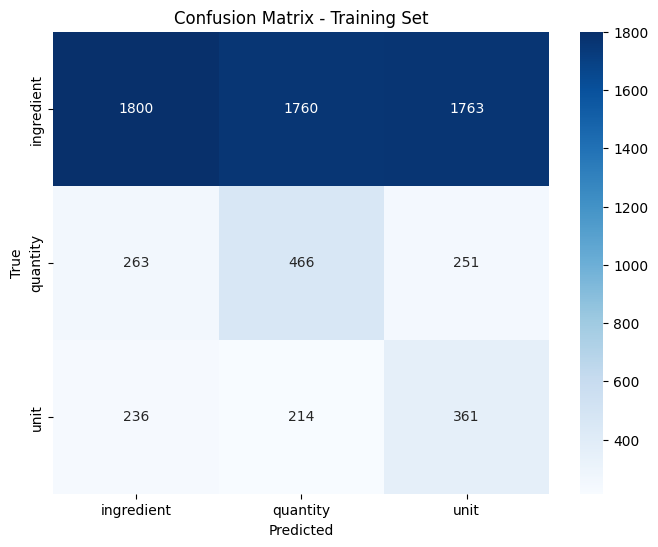

In [149]:
# create a confusion matrix on training datset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

# ---------------------------
# Predict on training data
# ---------------------------
y_pred_train = crf.predict(X_train)

# ---------------------------
# Flatten sequences for token-level evaluation
# ---------------------------
y_true_flat = list(chain.from_iterable(y_train))
y_pred_flat = list(chain.from_iterable(y_pred_train))

# ---------------------------
# Generate confusion matrix
# ---------------------------
labels = sorted(set(y_true_flat))  # all unique labels
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

# ---------------------------
# Visualize confusion matrix
# ---------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Training Set')
plt.show()


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [150]:
# dump the model using joblib as crf_model.pkl
import joblib

# ---------------------------
# Save CRF model to file
# ---------------------------
joblib.dump(crf, "crf_model.pkl")
print("CRF model saved as 'crf_model.pkl'")

# ---------------------------
# Load model later (optional)
# ---------------------------
# crf_loaded = joblib.load("crf_model.pkl")
# y_pred_loaded = crf_loaded.predict(X_val)


CRF model saved as 'crf_model.pkl'


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [151]:
# predict the crf model on validation dataset
# ---------------------------
# Predict on validation set
# ---------------------------
y_pred_val = crf.predict(X_val)

# ---------------------------
# Optional: evaluate performance
# ---------------------------
from sklearn_crfsuite import metrics

f1_val = metrics.flat_f1_score(y_val, y_pred_val, average='weighted')
print("Weighted F1-score on validation set:", f1_val)

# Detailed token-level classification report
report_val = metrics.flat_classification_report(y_val, y_pred_val, digits=3)
print("\nFlat classification report on validation set:\n")
print(report_val)


Weighted F1-score on validation set: 0.41438088382371857

Flat classification report on validation set:

              precision    recall  f1-score   support

  ingredient      0.768     0.340     0.471      2107
    quantity      0.207     0.496     0.292       411
        unit      0.151     0.405     0.220       358

    accuracy                          0.370      2876
   macro avg      0.375     0.414     0.328      2876
weighted avg      0.611     0.370     0.414      2876



In [152]:
# specify flat classification report
from sklearn_crfsuite import metrics

# ---------------------------
# Predict on validation set
# ---------------------------
y_pred_val = crf.predict(X_val)

# ---------------------------
# Generate flat classification report
# ---------------------------
report_val = metrics.flat_classification_report(
    y_val,          # true labels
    y_pred_val,     # predicted labels
    digits=3        # number of decimal places
)

print("Flat classification report on validation set:\n")
print(report_val)


Flat classification report on validation set:

              precision    recall  f1-score   support

  ingredient      0.768     0.340     0.471      2107
    quantity      0.207     0.496     0.292       411
        unit      0.151     0.405     0.220       358

    accuracy                          0.370      2876
   macro avg      0.375     0.414     0.328      2876
weighted avg      0.611     0.370     0.414      2876



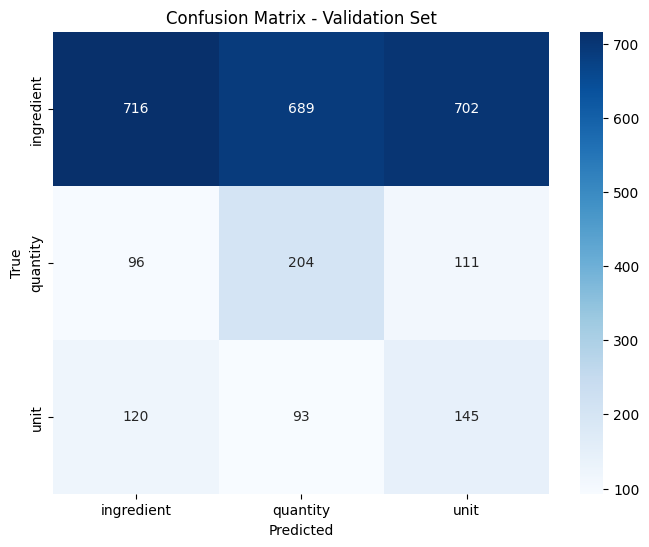

In [153]:
# create a confusion matrix on validation dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

# ---------------------------
# Predict on validation set
# ---------------------------
y_pred_val = crf.predict(X_val)

# ---------------------------
# Flatten sequences for token-level evaluation
# ---------------------------
y_true_flat = list(chain.from_iterable(y_val))
y_pred_flat = list(chain.from_iterable(y_pred_val))

# ---------------------------
# Generate confusion matrix
# ---------------------------
labels = sorted(set(y_true_flat))  # unique labels in dataset
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

# ---------------------------
# Visualize confusion matrix
# ---------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Set')
plt.show()


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [154]:
# flatten Labels and Initialise Error Data
from itertools import chain

# ---------------------------
# Flatten labels and predictions
# ---------------------------
y_true_flat = list(chain.from_iterable(y_val))      # true labels flattened
y_pred_flat = list(chain.from_iterable(y_pred_val)) # predicted labels flattened

# ---------------------------
# Initialize error data
# ---------------------------
# This will store tuples of (token_index, true_label, predicted_label)
error_data = []

for idx, (true_label, pred_label) in enumerate(zip(y_true_flat, y_pred_flat)):
    if true_label != pred_label:
        error_data.append((idx, true_label, pred_label))

print(f"Total misclassified tokens: {len(error_data)}")
# Example of first 10 errors
print("First 10 errors:", error_data[:10])


Total misclassified tokens: 1811
First 10 errors: [(7, 'ingredient', 'unit'), (8, 'unit', 'ingredient'), (9, 'ingredient', 'quantity'), (10, 'quantity', 'unit'), (11, 'unit', 'ingredient'), (12, 'ingredient', 'quantity'), (13, 'ingredient', 'unit'), (16, 'ingredient', 'unit'), (18, 'ingredient', 'quantity'), (19, 'quantity', 'unit')]


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [155]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases
from itertools import chain

# ---------------------------
# Flatten tokens and labels
# ---------------------------
tokens_flat = list(chain.from_iterable(X_val))  # X_val_tokens = list of token sequences
y_true_flat = list(chain.from_iterable(y_val))
y_pred_flat = list(chain.from_iterable(y_pred_val))

# ---------------------------
# Collect error information
# ---------------------------
error_data = []

for idx, (token, true_label, pred_label) in enumerate(zip(tokens_flat, y_true_flat, y_pred_flat)):
    if true_label != pred_label:
        # Handle previous token
        prev_token = tokens_flat[idx - 1] if idx > 0 else "<START>"
        # Handle next token
        next_token = tokens_flat[idx + 1] if idx < len(tokens_flat) - 1 else "<END>"

        error_data.append({
            "index": idx,
            "token": token,
            "true_label": true_label,
            "pred_label": pred_label,
            "prev_token": prev_token,
            "next_token": next_token
        })

print(f"Total misclassified tokens: {len(error_data)}")
print("First 10 errors:")
for e in error_data[:10]:
    print(e)


Total misclassified tokens: 1811
First 10 errors:
{'index': 7, 'token': 'Sugar', 'true_label': 'ingredient', 'pred_label': 'unit', 'prev_token': '3/4', 'next_token': 'tablespoon'}
{'index': 8, 'token': 'tablespoon', 'true_label': 'unit', 'pred_label': 'ingredient', 'prev_token': 'Sugar', 'next_token': 'Ghee'}
{'index': 9, 'token': 'Ghee', 'true_label': 'ingredient', 'pred_label': 'quantity', 'prev_token': 'tablespoon', 'next_token': '1/2'}
{'index': 10, 'token': '1/2', 'true_label': 'quantity', 'pred_label': 'unit', 'prev_token': 'Ghee', 'next_token': 'teaspoon'}
{'index': 11, 'token': 'teaspoon', 'true_label': 'unit', 'pred_label': 'ingredient', 'prev_token': '1/2', 'next_token': 'Cardamom'}
{'index': 12, 'token': 'Cardamom', 'true_label': 'ingredient', 'pred_label': 'quantity', 'prev_token': 'teaspoon', 'next_token': 'Powder'}
{'index': 13, 'token': 'Powder', 'true_label': 'ingredient', 'pred_label': 'unit', 'prev_token': 'Cardamom', 'next_token': 'Elaichi'}
{'index': 16, 'token': 'C

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [156]:
# Create DataFrame and Print Overall Accuracy
import pandas as pd

# ---------------------------
# Create DataFrame from error data
# ---------------------------
error_df = pd.DataFrame(error_data)

# Optional: show first few errors
print("First 10 errors:")
print(error_df.head(10))

# ---------------------------
# Compute overall token-level accuracy
# ---------------------------
total_tokens = len(y_true_flat)
correct_tokens = total_tokens - len(error_data)
accuracy = correct_tokens / total_tokens

print(f"Overall token-level accuracy: {accuracy:.3f}")


First 10 errors:
   index       token  true_label  pred_label  prev_token  next_token
0      7       Sugar  ingredient        unit         3/4  tablespoon
1      8  tablespoon        unit  ingredient       Sugar        Ghee
2      9        Ghee  ingredient    quantity  tablespoon         1/2
3     10         1/2    quantity        unit        Ghee    teaspoon
4     11    teaspoon        unit  ingredient         1/2    Cardamom
5     12    Cardamom  ingredient    quantity    teaspoon      Powder
6     13      Powder  ingredient        unit    Cardamom     Elaichi
7     16      Carrot  ingredient        unit           1      Gajjar
8     18     chopped  ingredient    quantity      Gajjar           7
9     19           7    quantity        unit     chopped    Potatoes
Overall token-level accuracy: 0.370


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [157]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

import pandas as pd
from itertools import chain

# ---------------------------
# Flatten tokens, true labels, and predicted labels
# ---------------------------
tokens_flat = list(chain.from_iterable(X_val))  # X_val_tokens = token sequences
y_true_flat = list(chain.from_iterable(y_val))
y_pred_flat = list(chain.from_iterable(y_pred_val))

# ---------------------------
# Initialize error data list
# ---------------------------
error_data = []

for idx, (token, true_label, pred_label) in enumerate(zip(tokens_flat, y_true_flat, y_pred_flat)):
    if true_label != pred_label:
        prev_token = tokens_flat[idx - 1] if idx > 0 else "<START>"
        next_token = tokens_flat[idx + 1] if idx < len(tokens_flat) - 1 else "<END>"
        error_data.append({
            "token": token,
            "prev_token": prev_token,
            "next_token": next_token,
            "true_label": true_label,
            "pred_label": pred_label,
            "context": f"{prev_token} {token} {next_token}"
        })

# ---------------------------
# Create DataFrame
# ---------------------------
error_df = pd.DataFrame(error_data)
print("First 10 token errors:")
print(error_df.head(10))

# ---------------------------
# Compute overall token-level accuracy
# ---------------------------
total_tokens = len(y_true_flat)
accuracy = (total_tokens - len(error_data)) / total_tokens
print(f"\nOverall token-level accuracy: {accuracy:.3f}")

# ---------------------------
# Per-label analysis
# ---------------------------
# Count total tokens per label
from collections import Counter
label_counts = Counter(y_true_flat)

# Count errors per label
error_counts = Counter(error_df['true_label'])

# Define your manual class weights
manual_class_weights = {
    'ingredient': 0.5,  # penalized
    'unit': 1.0,
    'quantity': 1.0,
    'O': 1.0
}

# Prepare analysis table
label_analysis = []
for label in label_counts:
    total = label_counts[label]
    errors = error_counts.get(label, 0)
    label_accuracy = (total - errors) / total
    weight = manual_class_weights.get(label, 1.0)
    label_analysis.append({
        "label": label,
        "total_tokens": total,
        "errors": errors,
        "accuracy": round(label_accuracy, 3),
        "class_weight": weight
    })

label_analysis_df = pd.DataFrame


First 10 token errors:
        token  prev_token  next_token  true_label  pred_label                   context
0       Sugar         3/4  tablespoon  ingredient        unit      3/4 Sugar tablespoon
1  tablespoon       Sugar        Ghee        unit  ingredient     Sugar tablespoon Ghee
2        Ghee  tablespoon         1/2  ingredient    quantity       tablespoon Ghee 1/2
3         1/2        Ghee    teaspoon    quantity        unit         Ghee 1/2 teaspoon
4    teaspoon         1/2    Cardamom        unit  ingredient     1/2 teaspoon Cardamom
5    Cardamom    teaspoon      Powder  ingredient    quantity  teaspoon Cardamom Powder
6      Powder    Cardamom     Elaichi  ingredient        unit   Cardamom Powder Elaichi
7      Carrot           1      Gajjar  ingredient        unit           1 Carrot Gajjar
8     chopped      Gajjar           7  ingredient    quantity          Gajjar chopped 7
9           7     chopped    Potatoes    quantity        unit        chopped 7 Potatoes

Overall 

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.